# Ensemble Methods in `sklearn`

## Random Forests

Random Forests are some of the most widespread classifiers used.  They are relatively simple to use (very few parameters to set and easy to avoid overfitting).  The key parameter to remember is `n_estimators` - the number of trees to use in the model.  There is also a `RandomForestRegressor` for regression instead of classification.

Advantages:
- Easy to tune, built-in protection against overfitting, no regularization
- Non-linear
- Built-in interaction effects

Disadvantages
- Slow
- Black-box
- No "coefficients", we don't know what positively or negatively impacts a website being evergreen

We can use a random forest to predict the categories of our 20-newsgroup dataset, which we already introduced in an earlier notebook.

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
import seaborn
%matplotlib inline

We'll use the 20-newsgroups dataset and the `TfidfVectorizer` we have introduced [earlier](../11_bayes/20_newsgroups.ipynb). In short, this is a collection of newsgroups articles that is well-known in the machine learning field. The `TfidfVectorizer` is a variation on the `CountVectorizer`. Please see the earlier notebook for more details.

In [20]:
categories = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
data = fetch_20newsgroups(subset='train', categories=categories)
print len(data.data), data.target_names

2034 ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [21]:
v = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1), min_df=2)
X = v.fit_transform(data.data)

### A Single Tree
We'll start training one decision tree.

In [34]:
%time model = DecisionTreeClassifier()
# print cross_val_score(tree_model, X_train.toarray(), twenty_train_subset.target)
print cross_val_score(model, X, data.target).mean()

CPU times: user 49 µs, sys: 7 µs, total: 56 µs
Wall time: 60.1 µs
0.794966928393


Not a bad start. Note that the distribution of categories is rather equal, so this is a good accuracy.

In [35]:
np.array(np.unique(data.target, return_counts=True)).T

array([[  0, 480],
       [  1, 584],
       [  2, 593],
       [  3, 377]])

### A Small Forest

Let's try a small forest with a number of trees.

In [49]:
%time model = RandomForestClassifier(n_estimators=20)
print cross_val_score(model, X_train, data.target).mean()

CPU times: user 184 µs, sys: 1 µs, total: 185 µs
Wall time: 189 µs
0.8687200983


Even better!
- Accuracy is higher than for a single tree.
- Note that the forest is not proportionally slower than a single tree.

### A Boosting Forest

`sklearn` has more ensemble methods that are worth trying out. The `GradientBoostingClassifier` is similar to a Random Forest, but uses a special algorithm of bagging the trees. This often leads to higher accuracies. It is quite slower, though.

In [50]:
# X_dense = X.todense()  # X.toarray()
# %time model = GradientBoostingClassifier(n_estimators=5)
# model.fit(X_dense, data.target)
# print cross_val_score(model, X_dense, data.target).mean()

## Optimizing Forests
The only option you really need to know is `n_estimators`, which indicates how many trees you'd like in yout forest.

There are however other options you could play with, if you're interested. One is which algorithm to use for splitting nodes: Gini or Entropy.

In [54]:
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  # let's time it, to see how long running a forest takes
        model = RandomForestClassifier(n_estimators=n, criterion=criterion)
        accuracy = cross_val_score(model, X_train, data.target).mean()  # out of sample accuracy
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores = pd.DataFrame(scores)

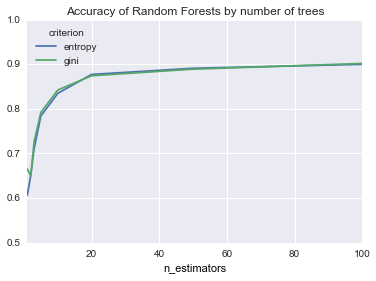

In [60]:
f = scores.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees")

Pretty good results.

Note that Entropy or Gini does not make a big difference.

## Getting Important Features

Instead of just predicting classes, we would like to get more insight about how features impact the classification.  Unfortunately, decision trees are not as interpretable as other models we have seen, and the interpretability only decreases as we apply ensemble methods.  This is why these methods are often called _black box_ methods.  Fortunately, though, Random Forests (and Decision Trees) _do_ indicate what features are important.  These 'feature importances' only tell us what features gave us the best splits – we do not see which feature had what impact on which class, as we saw with Logistic Regression and Naive Bayes.

As we saw before, getting information on what features we are using in Python can be difficult.  Each vectorizer has `get_feature_names` which we can use to tie back to our dataset.

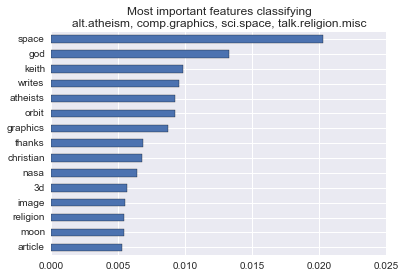

In [56]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, data.target)
coef = pd.Series(model.feature_importances_, index=v.get_feature_names()).sort(inplace=False)
f = coef[-15:].plot(kind='barh', title="Most important features classifying\n%s" % ", ".join(data.target_names))

Let's show some irrelevant features

In [57]:
print ", ".join(coef[coef == 0].index[:100])

integration, merge, meridian, merits, merkur, merton, mesh, meshes, mesosphere, mess, messages, messed, messengership, messy, metafile, metal, metallic, metaphor, metaphorical, metaphorically, metaphysically, metaphysics, merciful, mercies, menu, mentions, mediated, medical, medicine, mediterranean, medium, meek, meets, mega, megabyte, megabytes, metares, megs, melchizedek, mellenia, meme, memetic, memorable, memorial, memories, meng, menlo, mentally, mel, meteor, meteorological, methinks, mig, mighty, mik, mikelson, milan, mild, mileage, miles, militant, milk, midst, milkmen, millenia, millennia, millennium, millgram, milliseconds, milo, milton, milwaukee, mimas, mimi, milky, median, midnight, mid, methodically, methodists, methodology, metric, meyer, mfocus, mget, mgl, mhd, mica, middlesex, mice, microcomputer, microdata, microgravity, micrometeroid, micron, microscopes, microscopy, microware, microwave, microwaves


Makes quite sense.